# Spatial Interpolation

* process that uses known values from observations to estimate values at other unknown locations


__Exercise Problem:__
Interpolating temperature in Ohio from weather station records

## 1.1 Package Imports

In [1]:
import pandas as pd
import geopandas as gpd
import pykrige
from pyidw import idw
from sklearn.metrics import mean_squared_error
import rasterio
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## 1.2 Data Import

In [2]:
path = '../Data/Data_pt1/'

In [3]:
# Ohio Shapefile
ohio = gpd.read_file(path + "Ohio/Ohio.shp")
ohio_state = ohio.dissolve()
ohio_state = ohio_state[['STATEFP','geometry']]
ohio_state = ohio_state.to_crs("EPSG:4326")
ohio_state.to_file(path + "Ohio/Ohio_State.shp")

# Ohio Temperatures
temps = pd.read_csv(path + "Chapter 11/Ohio Temps.csv")
temps = temps[~temps['TAVG'].isnull()]
temps = temps[temps['DATE']=='2022-01-01']
temps = temps[['LATITUDE','LONGITUDE','TAVG']]

# Converting to geopandas and writing out as shapefile
temps_gpdf = gpd.GeoDataFrame(
    temps,
    geometry=gpd.points_from_xy(temps['LONGITUDE'],
                                   temps['LATITUDE'],
                                   crs="EPSG:4326")
)

# Output the shapefile
temps_gpdf.to_file(path + "Chapter 11/Ohio Temps.shp")


/var/folders/b2/d7c60fp557555jg6jbxm1f4r0000gn/T/ipykernel_15400/3455191.py:9: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  temps = pd.read_csv(path + "Chapter 11/Ohio Temps.csv")


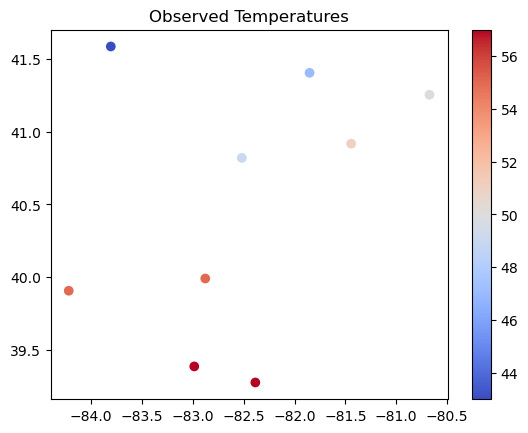

In [5]:
# plotting data
temps_nogeom = temps
# Converting the DataFrame to a numpy array
temps_array = temps_nogeom.to_numpy()

# Plot the observations
obs = plt.scatter(temps_array[:, 1],
    temps_array[:, 0],
    c = temps_array[:, 2], cmap='coolwarm')
cbar = plt.colorbar(obs)
plt.title('Observed Temperatures')
plt.show()

# 2.0 Spatial Interpolation

## 2.1 Inverse Distance Weighted (IDW) Interpolation

* uses sampled points to infer the value at an unknown location, where the effect of the sampled point on the prediction of the interpolated point diminishes as the distance between the sampled and interpolated point increases
* __Tobler's First Law of Geographuy:__ "_everything is related, but near things are more related than distant things_"
* _pyidw_ package

/Users/sarahamundrud/opt/anaconda3/envs/geospatial_ds/lib/python3.10/site-packages/pyidw/idw.py:110: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  minX = floor(calculationExtent.bounds.minx)
/Users/sarahamundrud/opt/anaconda3/envs/geospatial_ds/lib/python3.10/site-packages/pyidw/idw.py:111: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  minY = floor(calculationExtent.bounds.miny)
/Users/sarahamundrud/opt/anaconda3/envs/geospatial_ds/lib/python3.10/site-packages/pyidw/idw.py:112: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  maxX = ceil(calculationExtent.bounds.maxx)
/Users/sarahamundrud/opt/anaconda3/envs/geospatial_ds/lib/python3.10/site-packages/pyidw/idw.py:113: FutureWarning: Calling float o

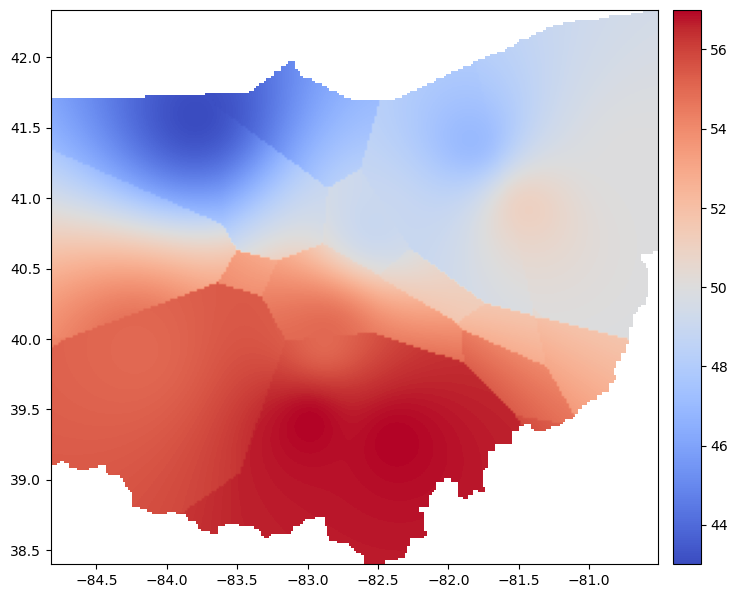

In [6]:
# call idw.idw_intperpolation function to perform IDW interpolation
idw.idw_interpolation(
    input_point_shapefile=path + "Chapter 11/Ohio Temps.shp",
    extent_shapefile=path + "Ohio/Ohio_State.shp",
    column_name="TAVG",
    power=2,
    search_radious=3,
    output_resolution=250
)

__Limitations:__
* resulting interpolationsaccuracy can decrtease if the distribution of the sampled points is unevently distributed across study area
* IDW method cannot produce interpolate values that are outside the mininum or maximum of the observed values

---

## 2.2 Oridinary Kriging Interpolation

__Kriging-based interpolation__
* Kriging leverages distance similarly to IDW interpolation but als leverages the degree of variation in sampled data points
* estimates are produced using a weighted linear combination of the sampled values around the unknown point
* spatial autocorrelation beween the points needs to be measured using a fitted model to the observed points
* __variography__: process of fitting a model
* __semivariogram__: fitted model
* once semivariogram is calculated, a model is fit to the points (empirical semivariogram)
    * model is fit to points similar to multiple regression model, ehrtr msny gunvyiond vsn nr giy yo yhr poinyd
* several variogram models, e.g., Gaussian, exponential, spherical, and linear
* _pykrige_ package

In [7]:
# Package Imports
import matplotlib.pyplot as plt
import numpy as np
import pykrige.kriging_tools as kt
from pykrige.ok import OrdinaryKriging

In [8]:
## identify minimum and maximum lat and long and create a grid

min_x = min(temps_nogeom['LONGITUDE'])
max_x = max(temps_nogeom['LONGITUDE'])
min_y = min(temps_nogeom['LATITUDE'])
max_y = max(temps_nogeom['LATITUDE'])

gridx = np.arange(min_x, max_x, 0.1, dtype='float64')
gridy = np.arange(min_y, max_y, 0.1, dtype='float64')

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'gaussian' Variogram Model
Partial Sill: 22.76639814484606
Full Sill: 22.766398144846235
Range: 2.3536346538901984
Nugget: 1.7377125180938841e-13 



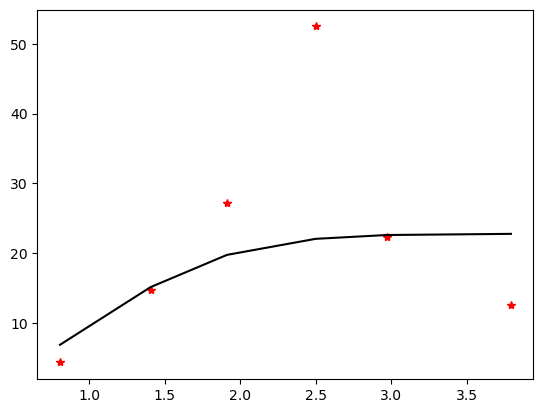

Calculating statistics on variogram model fit...


In [9]:
## Fit the semivariogram and plot empirical semivariogram using Gaussian model

Orid_Krig = OrdinaryKriging(
    temps_array[:, 1], #Longitude vector
    temps_array[:, 0], #Latitude vector
    temps_array[:, 2], #Temperatures vector
    variogram_model="gaussian", #The semivariogram model
    verbose=True, #True writes out the steps as they're being performed
    enable_plotting=True # True plots the emperical semivariogram
)

In [10]:
# Interpolate the values using the kriging model
z, ss = Orid_Krig.execute("grid", gridx, gridy)

Executing Ordinary Kriging...



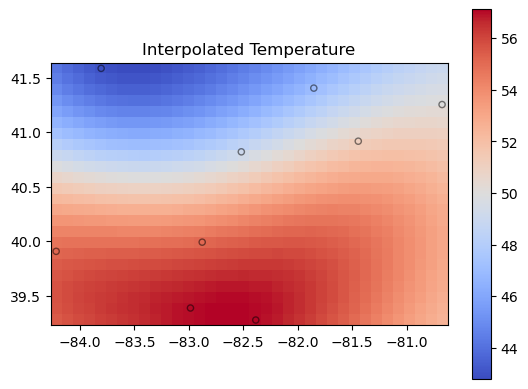

In [11]:
# Plot the interpolarted values and sampled points
im = plt.imshow(z, extent=[min_x-.05, max_x+.05, min_y-.05, max_y+.05], origin='lower', cmap='coolwarm')
plt.scatter(temps_array[:, 1],
    temps_array[:, 0],
    c = temps_array[:, 2], alpha=.5, marker='o', s=20, edgecolors='black', linewidth=1, cmap='coolwarm')
cbar = plt.colorbar(im)
plt.title("Interpolated Temperature")
plt.show()